In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import takewhile
from PIL import ImageFont
from matplotlib.font_manager import findfont, FontProperties
import locale
from os import path
from glob import glob
from re import findall
from datetime import datetime

# Set locale to "it" to parse the month correctly
locale.setlocale(locale.LC_ALL, "it_IT.UTF-8")
plt.style.use('default')

In [2]:
def date_from_url(csv_path):
    date_ = findall(r"\d+-\d+-\d+", csv_path)[0]
    return datetime.strptime(date_, "%Y-%m-%d")

In [3]:
# lista i csv
file_path = '../dati/data_iss_età_*.csv'
files = sorted(glob(file_path), key=path.getmtime, reverse=True)

files

['../dati\\data_iss_età_2021-09-29.csv',
 '../dati\\data_iss_età_2021-09-08.csv',
 '../dati\\data_iss_età_2021-09-15.csv',
 '../dati\\data_iss_età_2021-09-22.csv']

## Importa dati divisi per fasce d'età
Report del 15 Settembre, https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_15-settembre-2021.pdf
I dati si riferiscono ai 30 giorni precedenti

In [4]:
# recupera data csv
csv_date = date_from_url(files[0])

csv_date_d = csv_date.strftime("%d")
csv_date_m = csv_date.strftime("%B")
report_date = f'{csv_date_d}-{csv_date_m}-{csv_date.year}'

message = f'Report ISS del {csv_date_d} {csv_date_m.capitalize()}: '
message += f'https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_{report_date}.pdf. '
message += 'I dati si riferiscono ai 30 giorni precedenti.'

print(message)

Report ISS del 29 Settembre: https://www.epicentro.iss.it/coronavirus/bollettino/Bollettino-sorveglianza-integrata-COVID-19_29-settembre-2021.pdf. I dati si riferiscono ai 30 giorni precedenti.


In [5]:
df_età = pd.read_csv(files[0], sep=';')

df_età

,età,non vaccinati,vaccinati completo,casi non vaccinati,casi vaccinati,ospedalizzati non vaccinati,ospedalizzati vaccinati,terapia intensiva non vaccinati,terapia intensiva vaccinati,decessi non vaccinati,decessi vaccinati
0,12-39,5623726,8771385,38923,9701,1427,102,67,4,15,2
1,40-59,4250568,12903074,22971,14602,2310,307,277,17,135,16
2,60-79,1637926,11551322,7353,10901,1750,834,335,99,425,145
3,80+,274400,4192014,1653,4856,673,1175,38,54,352,402


## Elaborazione dati

In [6]:
# ricava i tassi, dividendo per la popolazione vaccinati e non vaccinata
tassi = (7/30)*10**5*np.transpose([df_età['casi non vaccinati']/df_età['non vaccinati'],
         df_età['casi vaccinati']/df_età['vaccinati completo'],                  
         df_età['ospedalizzati non vaccinati']/df_età['non vaccinati'],
         df_età['ospedalizzati vaccinati']/df_età['vaccinati completo'],
         df_età['terapia intensiva non vaccinati']/df_età['non vaccinati'],
         df_età['terapia intensiva vaccinati']/df_età['vaccinati completo'],
         df_età['decessi non vaccinati']/df_età['non vaccinati'],
         df_età['decessi vaccinati']/df_età['vaccinati completo']])


df_tassi = pd.DataFrame(tassi)
df_tassi.columns = ['Casi, non vaccinati',
                    'Casi, vaccinati',
                    'Ospedalizzati, non vaccinati', 
                    'Ospedalizzati, vaccinati',
                    'In terapia intensiva, non vaccinati',
                    'In terapia intensiva, vaccinati',
                    'Deceduti, non vaccinati',
                    'Deceduti, vaccinati']

df_tassi.index = df_età['età']

df_tassi

,"Casi, non vaccinati","Casi, vaccinati","Ospedalizzati, non vaccinati","Ospedalizzati, vaccinati","In terapia intensiva, non vaccinati","In terapia intensiva, vaccinati","Deceduti, non vaccinati","Deceduti, vaccinati"
età,,,,,,,,
12-39,161.494947,25.806263,5.920748,0.271337,0.277989,0.010641,0.062236,0.005320
40-59,126.098441,26.405594,12.680658,0.555165,1.520581,0.030742,0.741077,0.028934
60-79,104.748322,22.019702,24.929901,1.684656,4.772295,0.199977,6.054405,0.292896
80+,140.561224,27.029172,57.227891,6.540214,3.231293,0.300572,29.931973,2.237588


## Rappresentazione grafica dei risultati

### Funzioni per plot

In [7]:
def which_axe(x):
    axes[x].set_ylabel('Ogni 100.000 persone per ciascun gruppo')
    axes[x].set_xlabel('Fascia d\'età')
    axes[x].legend(['Non vaccinati', 'Vaccinati'])
    axes[x].grid()
    for tick in axes[x].get_xticklabels():
        tick.set_rotation(0)

def add_to_plot():
    plt.ylim(70, 100)
    plt.grid()
    plt.xlabel('Fascia d\'età')
    plt.yticks(np.arange(70, 101, 5), ['70%', '75%', '80%', '85%', '90%', '95%', '100%'])

def watermark_specs(figure, watermark):
    # Get the default Matplotlib font
    default_font = findfont(FontProperties(family=['sans-serif']))
    
    # Fraction of the image where the Watermark is placed
    figure_fraction = 0.6
    
    # Get Figure width, height (Pixels)
    figure_wd = figure.get_figwidth() * figure.dpi
    figure_ht = figure.get_figheight() * figure.dpi
    
    # Get Watermark width (Pixels)
    watermark_wd = int(figure_fraction * figure_wd)

    # Calculate the scaled fontsize - iterate until the text size is larger than the text width and take the max value
    fontsize = max(takewhile(lambda i: ImageFont.truetype(default_font, i).getsize(watermark)[0] < watermark_wd, 
                    range(1, watermark_wd))) - 1
    # Calculate appropriate rotation and convert to degree (r * 180°/pi)
    angle = np.arctan(figure_ht/figure_wd)*(180/np.pi)

    # Multiply by -1 to flip text horizontally
    angle *= -1

    print(f"watermark fontsize: {fontsize}, angle:{round(angle, 2)}")
    return fontsize, angle

def add_watermark(figure, axis_font_size):
    watermark = 'github.com/apalladi/covid_monitoraggio_vaccini'
    # Get the scaled watermark fontsize and angle
    fontsize, angle = watermark_specs(figure, watermark)
    figure.text(0.5, 
                0.5, 
                watermark,
                fontsize=fontsize, 
                color='gray', 
                alpha=0.25,
                ha='center', 
                va='center', 
                rotation=angle, 
                zorder=0
                )

    # explicit link and last update date at the bottom
    last_update = datetime.today().strftime('%d-%m-%Y %H:%M')
    watermark_btm = r'$\bf{Fonte:}$ https://github.com/apalladi/covid_vaccini_monitoraggio'
    watermark_btm += f'\n Ultimo aggiornamento: {last_update}'
    figure.text(0.5, 
                -0.06, 
                watermark_btm,
                fontsize=axis_font_size,
                color='darkslategray', 
                ha="center", 
                va="bottom"
                )

def which_axe_bar(x):
    axes[x].set_ylim(80, 100)
    axes[x].set_yticks(np.arange(70, 101, 5))
    axes[x].set_yticklabels(['70%', '75%', '80%', '85%', '90%', '95%', '100%'])
    axes[x].set_xlabel('Fascia d\'età')
    axes[x].grid()
    for tick in axes[x].get_xticklabels():
        tick.set_rotation(0)


### Tassi di contagio

watermark fontsize: 18, angle:-45.0


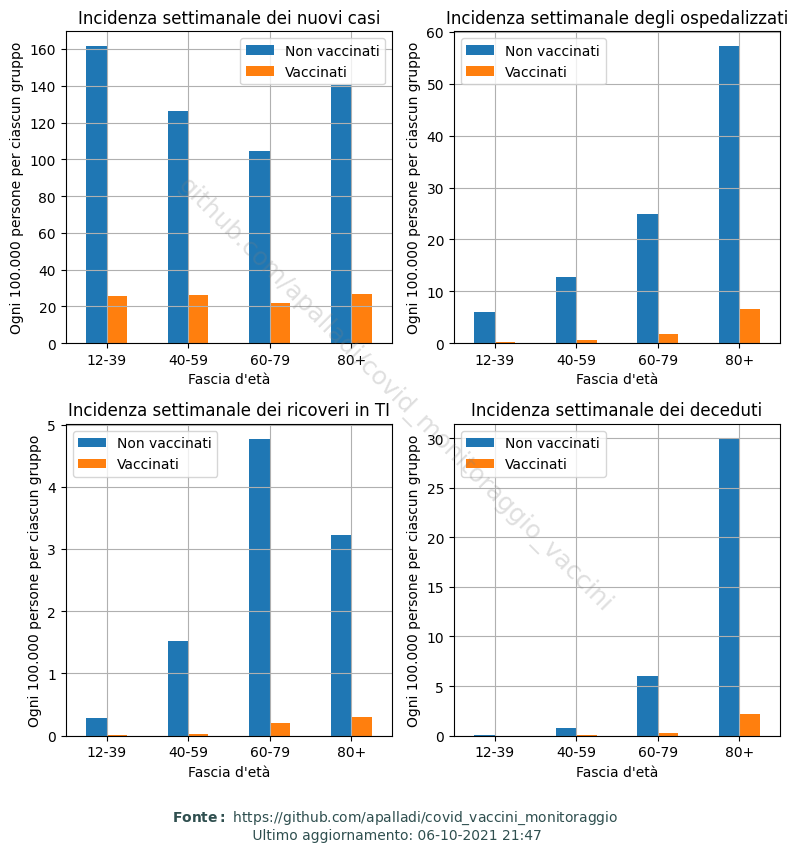

In [8]:
fig, axes2 = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# unpack all the axes subplots
axes = axes2.ravel()

df_tassi.iloc[:, [0, 1]].plot(ax=axes[0],kind='bar')
axes[0].set_title('Incidenza settimanale dei nuovi casi')
which_axe(0)

df_tassi.iloc[:, [2, 3]].plot(ax=axes[1], kind='bar')
axes[1].set_title('Incidenza settimanale degli ospedalizzati')
which_axe(1)

df_tassi.iloc[:, [4, 5]].plot(ax=axes[2], kind='bar')
axes[2].set_title('Incidenza settimanale dei ricoveri in TI')
which_axe(2)

df_tassi.iloc[:, [6, 7]].plot(ax=axes[3], kind='bar')
axes[3].set_title('Incidenza settimanale dei deceduti')
which_axe(3)

# add watermarks
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())

plt.tight_layout()
plt.savefig('../risultati/tassi_per_età.png', dpi=300, bbox_inches="tight")
plt.show()

### Efficacia dei vaccini

In [9]:
efficacia_contagio = (1 - df_tassi.iloc[:, 1]/df_tassi.iloc[:, 0])*100
efficacia_osp = (1 - df_tassi.iloc[:, 3]/df_tassi.iloc[:, 2])*100
efficacia_terint = (1 - df_tassi.iloc[:, 5]/df_tassi.iloc[:, 4])*100
efficacia_decessi = (1 - df_tassi.iloc[:, 7]/df_tassi.iloc[:, 6])*100

watermark fontsize: 21, angle:-45.0


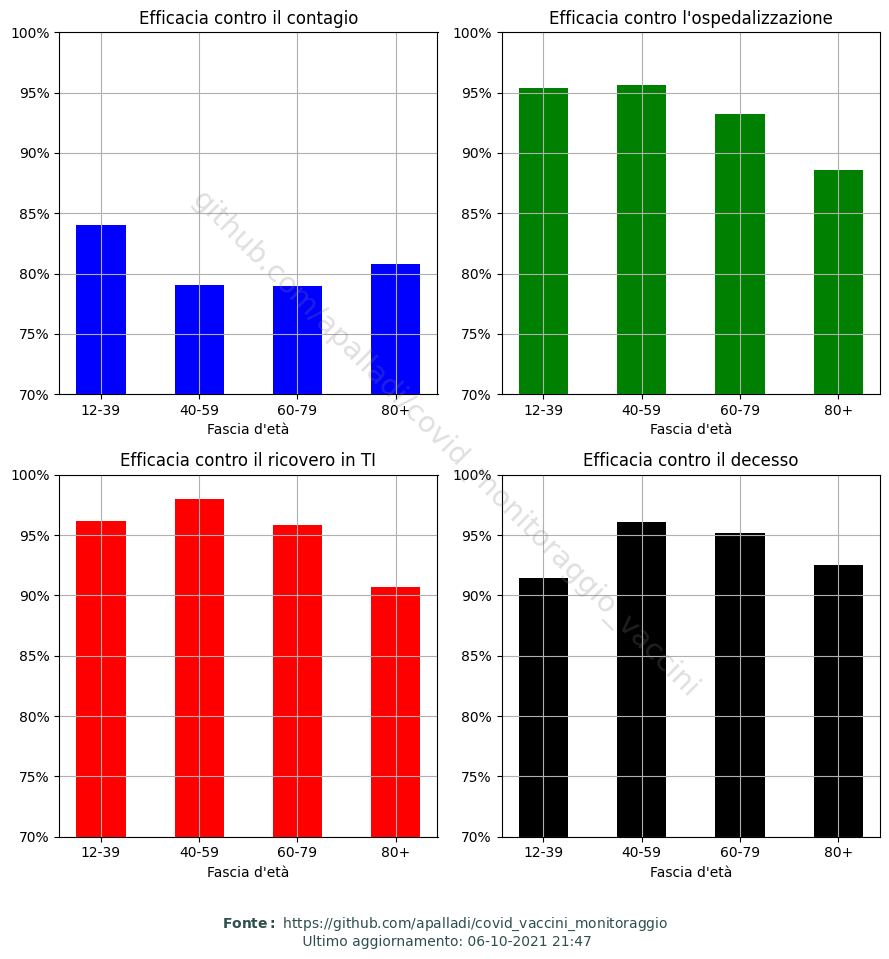

In [10]:
fig = plt.figure(figsize=(9, 9))

plt.subplot(2, 2, 1)
plt.bar(efficacia_contagio.index, efficacia_contagio, color='blue', width=0.5)
plt.title('Efficacia contro il contagio')
add_to_plot()

plt.subplot(2, 2, 2)
plt.bar(efficacia_osp.index, efficacia_osp, color='green', width=0.5)
plt.title('Efficacia contro l\'ospedalizzazione')
add_to_plot()

plt.subplot(2, 2, 3)
plt.bar(efficacia_terint.index, efficacia_terint, color='red', width=0.5)
plt.title('Efficacia contro il ricovero in TI')
add_to_plot()

plt.subplot(2, 2, 4)
plt.bar(efficacia_decessi.index, efficacia_decessi, color='black', width=0.5)
plt.title('Efficacia contro il decesso')
add_to_plot()

# add watermarks
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())

plt.tight_layout()
plt.savefig('../risultati/efficacia_vaccini.png', dpi=300, bbox_inches="tight")
plt.show()

### Grafico riassuntivo

watermark fontsize: 36, angle:-28.07


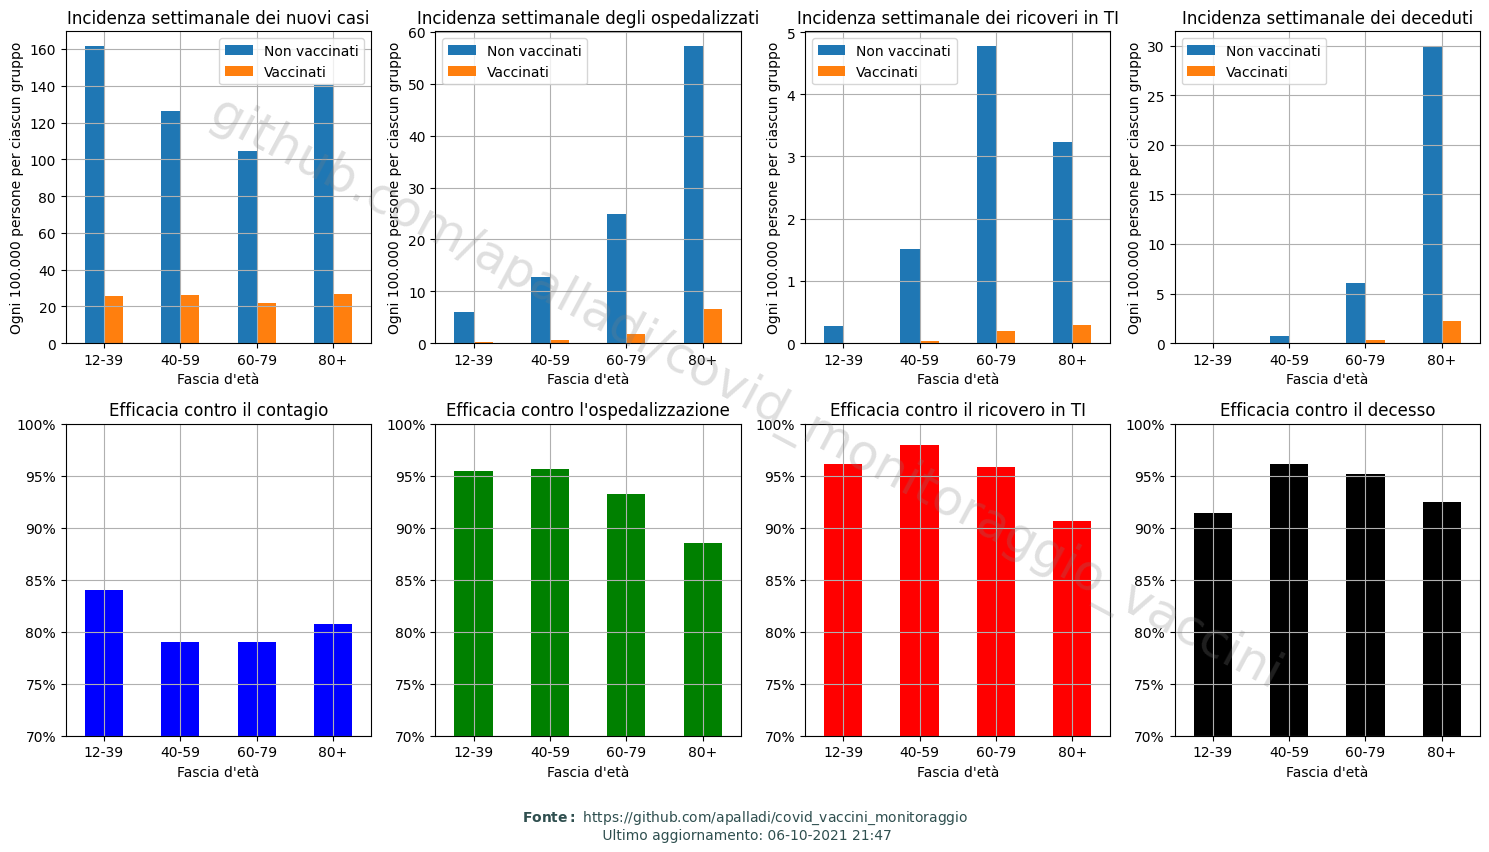

In [11]:
fig, axes2 = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))

# unpack all the axes subplots
axes = axes2.ravel()

df_tassi.iloc[:, [0, 1]].plot(ax=axes[0],kind='bar')
axes[0].set_title('Incidenza settimanale dei nuovi casi')
which_axe(0)

df_tassi.iloc[:, [2, 3]].plot(ax=axes[1], kind='bar')
axes[1].set_title('Incidenza settimanale degli ospedalizzati')
which_axe(1)

df_tassi.iloc[:, [4, 5]].plot(ax=axes[2], kind='bar')
axes[2].set_title('Incidenza settimanale dei ricoveri in TI')
which_axe(2)

df_tassi.iloc[:, [6, 7]].plot(ax=axes[3], kind='bar')
axes[3].set_title('Incidenza settimanale dei deceduti')
which_axe(3)

efficacia_contagio.plot(kind='bar', ax=axes[4], color='blue')
axes[4].set_title('Efficacia contro il contagio')
which_axe_bar(4)

efficacia_osp.plot(kind='bar', ax=axes[5], color='green')
axes[5].set_title('Efficacia contro l\'ospedalizzazione')
which_axe_bar(5)

efficacia_terint.plot(kind='bar', ax=axes[6], color='red')
axes[6].set_title('Efficacia contro il ricovero in TI')
which_axe_bar(6)

efficacia_decessi.plot(kind='bar', ax=axes[7], color='black')
axes[7].set_title('Efficacia contro il decesso')
which_axe_bar(7)

# add watermarks
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())

plt.tight_layout()
plt.savefig('../risultati/tassi_efficacia.png', dpi=300, bbox_inches="tight")
plt.show()

### Focus sugli over 60

In [12]:
df_over60 = df_età.loc[[2,3], ['non vaccinati', 'vaccinati completo', 
                'terapia intensiva non vaccinati', 'terapia intensiva vaccinati',
                'decessi non vaccinati', 'decessi vaccinati']].sum()

df_over60

non vaccinati                       1912326
vaccinati completo                 15743336
terapia intensiva non vaccinati         373
terapia intensiva vaccinati             153
decessi non vaccinati                   777
decessi vaccinati                       547
dtype: int64

In [13]:
over60_array = np.array(df_over60)

label_date = f'{csv_date_d} {csv_date.strftime("%b").capitalize()}'

watermark fontsize: 29, angle:-18.43


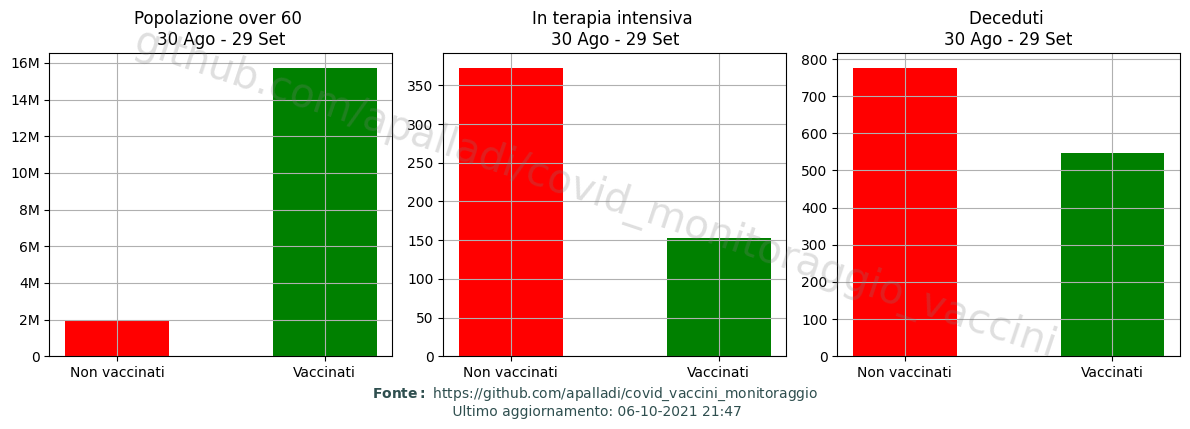

In [14]:
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.bar(0, over60_array[0], width=0.5, color='red')
plt.bar(1, over60_array[1], width=0.5, color='green')
plt.xticks([0, 1], ['Non vaccinati', 'Vaccinati'])
plt.yticks(10**6*np.arange(0, 17, 2), ['0', '2M', '4M', '6M', '8M', '10M', '12M', '14M', '16M'])
plt.grid()
plt.title(f'Popolazione over 60 \n30 Ago - {label_date}')

plt.subplot(1, 3, 2)
plt.bar(0, over60_array[2], width=0.5, color='red')
plt.bar(1, over60_array[3], width=0.5, color='green')
plt.xticks([0, 1], ['Non vaccinati', 'Vaccinati'])
plt.grid()
plt.title(f'In terapia intensiva \n30 Ago - {label_date}')

plt.subplot(1, 3, 3)
plt.bar(0, over60_array[4], width=0.5, color='red')
plt.bar(1, over60_array[5], width=0.5, color='green')
plt.xticks([0, 1], ['Non vaccinati', 'Vaccinati'])
plt.grid()
plt.title(f'Deceduti \n30 Ago - {label_date}')

# add watermarks
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())

plt.tight_layout()
plt.savefig('../risultati/focus_over60.png', dpi=300, bbox_inches="tight")
plt.show()

In [15]:
ratio_vacc_novacc = round(over60_array[1]/over60_array[0], 1)
ratio_terint = round(over60_array[2]/over60_array[3], 1)
ratio_dec = round(over60_array[4]/over60_array[5], 1)

print('Rapporto tra vaccinati e non vaccinati', ratio_vacc_novacc)
print('Rapporto tra ricoverati in terapia intensiva (novacc/vacc)', ratio_terint)
print('Rapporto tra deceduti (novacc/vacc)', ratio_dec)

Rapporto tra vaccinati e non vaccinati 8.2
Rapporto tra ricoverati in terapia intensiva (novacc/vacc) 2.4
Rapporto tra deceduti (novacc/vacc) 1.4


In [16]:
print('Peso sul sistema sanitario di un non vaccinato over 60:', round(ratio_vacc_novacc*ratio_terint, 2))
print('Peso sulla mortalità di un non vaccinato over 60:      ', round(ratio_vacc_novacc*ratio_dec, 2))

Peso sul sistema sanitario di un non vaccinato over 60: 19.68
Peso sulla mortalità di un non vaccinato over 60:       11.48
